In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import random
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Dataset with sequences and labels (1 if increasing sequence, else 0)
class SeqDataset(Dataset):
    def __init__(self, size=2000, seq_len=4):
        self.data = []
        for _ in range(size):
            seq = [random.randint(0, 9) for _ in range(seq_len)]
            label = 1 if all(x < y for x, y in zip(seq, seq[1:])) else 0
            self.data.append((torch.tensor(seq), torch.tensor(label)))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [3]:
# Dataloaders
train_loader = DataLoader(SeqDataset(size=2000), batch_size=32, shuffle=True)
test_loader = DataLoader(SeqDataset(size=200), batch_size=32)

In [4]:
# RNN Model (can choose lstm, gru, or rnn)
class RNNClassifier(nn.Module):
    def __init__(self, rnn_type='lstm', hidden_dim=16, dropout=0.0):
        super().__init__()
        self.embed = nn.Embedding(10, 8)
        rnn_dict = {'rnn': nn.RNN, 'lstm': nn.LSTM, 'gru': nn.GRU}
        self.rnn = rnn_dict[rnn_type](input_size=8, hidden_size=hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, 1)
        self.act = nn.Sigmoid()
        self.rnn_type = rnn_type

    def forward(self, x):
        x = self.embed(x)
        if self.rnn_type == 'lstm':
            _, (h, _) = self.rnn(x)
        else:
            _, h = self.rnn(x)
        out = self.fc(h[-1])
        return self.act(out).squeeze()

In [5]:
#training
def train(model):
    loss_fn = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.01)
    model.train()

    for epoch in range(5):
        for x, y in train_loader:
            out = model(x)
            loss = loss_fn(out, y.float())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1} - Loss: {loss.item():.4f}")


In [6]:
def evaluate(model):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for x, y in test_loader:
            out = model(x)
            preds = (out > 0.5).int()
            all_preds.extend(preds.cpu().tolist())
            all_labels.extend(y.cpu().tolist())

    acc = accuracy_score(all_labels, all_preds)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"\nAccuracy: {acc * 100:.2f}%")
    print("Confusion Matrix:")
    print(cm)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt="d", cmap="viridis",
                xticklabels=["Not Increasing", "Increasing"],
                yticklabels=["Not Increasing", "Increasing"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn(


Epoch 1 - Loss: 0.0270
Epoch 2 - Loss: 0.1944
Epoch 3 - Loss: 0.0120
Epoch 4 - Loss: 0.0549
Epoch 5 - Loss: 0.0007

Accuracy: 98.50%
Confusion Matrix:
[[197   0]
 [  3   0]]


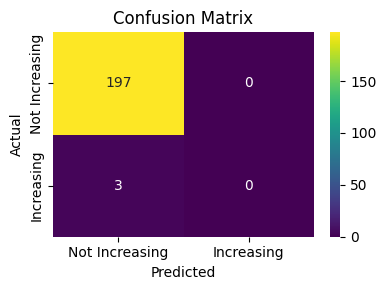

In [7]:
# Try different rnn_type: 'rnn', 'lstm', 'gru'
model = RNNClassifier(rnn_type='gru', hidden_dim=32, dropout=0.1)
train(model)
evaluate(model)